# Predicting Porosity from Seismic P-wave Velocity
## Kelly Olsen - kolsen@utexas.edu
### Subsurface Machine Learning Final Project (GEO 391) - Fall 2019
### Instructor: Michael Pyrcz
### University of Texas at Austin


## Executive Summary

The goal of this was to use velocity data from a seismic reflection survey to predict porosity in the sediments at the south-central Chile subduction zone using three different models that vary in complexity, and to evaluate whether it is necessary to use a more complicated model. I have created a basic decision tree model, an ensemble, random forest model, and a random forest model where I optimized parameter values for max depth and minimum leaf split. The result is three different models that look very similar. The correlation coefficients on the testing data were all very high (>0.95). The grid search random forest took longer to instantiate the model, and only performed marginally better. Therefore, I would recommend the random forest approach -- it produces a smoother model than a single decision tree, and performs only slightly worse than the grid search random forest.

## Introduction
I will be using a seismic reflection dataset where I have previously picked seismic velocities. The dataset was collected off of south-central Chile using a 15.15-km-long streamer, so the velocity data within flat-lying sediments is fairly well constrained. This dataset is currently part of a publication that is in review (Thick, strong sediment subduction along south-central Chile and its role in great earthquakes, Olsen, K.M.,Bangs, N. L, Tréhu, A. M.,
Han, S, Arnulf, A; Contreras Reyes, E., Earth and Planetary Science Letters, in review).

A core also exists in this area, and porosity measurements were taken on the core. However, the porosity data does not extend through the entire sediment section, so values will need to be interpolated based on a porosity vs depth trend (general compaction trend, see below).

The goal of this workflow is to predict porosity using three models of varying complexity, and compare their performance. The models are all based on decision trees - one is a simple decision tree, one a random forest, and finally, a gridded-searched random forest, which tries to best estimate the parameters of random forest using an exhaustive method. The models are evaluated by comparing the correlation coefficients and comparing 2D velocity images.

There are many advantages for using decision trees. For one, they are simple and easy to interpret. This is not a very complex problem, since only one predictor feature is used, but the relationship between velocity and porosity is slightly more complicated. This method allows us to not make any assumptions about how velocity changes with porosity. Decision trees also require little data preparation (i.e. less sensitive to outliers/missing data) and data type is not a constraint, it's easy to evaluate how the model is doing statistically, and can quickly be applied to large datasets (for instance, I could implement this quickly for the other 13 seismic lines I have in this area). More information on decision trees and the packages I use can be found here: https://scikit-learn.org/stable/modules/tree.html#tree and here: https://scikit-learn.org/stable/modules/ensemble.html#ensemble

The other packages are shown below: I use matplotlib (https://matplotlib.org/) and seaborn (https://seaborn.pydata.org/) to visualize, and scikit-learn to split the data (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). I also keep everything in a pandas dataframe (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) -- this makes it super easy to use.

In [1]:
#importing necessary packages
import os
import math
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split        # train and test split

from sklearn.tree import DecisionTreeRegressor              # decision tree method
from sklearn.ensemble import RandomForestRegressor          # random forest method

from sklearn.model_selection import GridSearchCV            # gridded search to tune the hyperparameters


I've imported the packages I need, and will also define a super simple function I use a few times below to round to a certain base.

In [2]:
def baseround(x, base):
    return base * round(x/base)

I'm also setting my directory so I have access to all the necessary files.

In [3]:
os.chdir('/Users/kellyolsen/Documents/Classes/ML2019/Project')

## Data
Importing the velocity dataset. The dataset is a 2D velocity file (in depth) created from normal move-out analysis, which involves fitting a curve to a offset vs time dataset (some of my PhD work). The dataset is CDP (common dip point, a spatial point), depth, and velocity for a given line (here's some more information on velocity analysis if you want to know more: https://wiki.seg.org/wiki/Velocity_analysis). The velocity profile has been smoothed.

The values are sampled every 100 cdps (625 m) and every 5 m in depth (the smallest sampling interval based on my the sampling rate of the data in time). The velocity data is regularly sampled, and the uncertainty is estimated at ~2-5% of the velocity values (Olsen et al., in review).

In [4]:
df = pd.read_csv('028vels')
df.columns = ['Line','CDP','Depth','Velocity']
df.head()

,Line,CDP,Depth,Velocity
0,28,9000,5,1499
1,28,9000,10,1499
2,28,9000,15,1499
3,28,9000,20,1499
4,28,9000,25,1499


The second dataset I need is the core data from a site (1232) very close to this seismic line, cored by what is now the International Ocean Discovery Program (http://iodp.tamu.edu/database/). These data are not regularly-sampled, and have some noise. The porosity data (which I am interested in) are measured using Moisture and density (MAD) porosity measurements on the core itself (more information on that here: http://www-odp.tamu.edu/publications/tnotes/tn37/tn37_8.htm)

In [5]:
coredata = pd.read_table('por_data.txt')
coredata.rename(columns={'ite':'Site'},inplace = True)
coredata.head()

,Site,H,Cor,T,Sc,Top(cm),Bot(cm),Depth (mbsf),WW (%),WD (%),BD (g/cc),DD (g/cc),GD (g/cc),PO (%),VR,Method,Comments
202,1232,A,1,H,1,74.0,76.0,0.74,52.6,110.9,1.463,0.694,2.787,75.1,3.018,C,
202,1232,A,1,H,2,74.0,76.0,2.25,43.0,75.5,1.619,0.923,2.886,68.0,2.128,C,
202,1232,A,1,H,3,74.0,76.0,3.75,44.3,79.4,1.575,0.878,2.751,68.1,2.134,C,
202,1232,A,1,H,4,74.0,76.0,5.26,30.1,43.0,1.835,1.283,2.784,53.9,1.169,C,
202,1232,A,1,H,5,74.0,76.0,6.76,42.0,72.5,1.615,0.936,2.780,66.3,1.970,C,


I only really plan on using porosity (and need depth to tie to the seismic data), so I'll add this to another dataframe. I could keep all of the data, but I'd like to not have to index it everytime.

In [6]:
working_data = coredata[['Depth (mbsf)','PO (%)']]
working_data.head()

,Depth (mbsf),PO (%)
202,0.74,75.1
202,2.25,68.0
202,3.75,68.1
202,5.26,53.9
202,6.76,66.3


The last dataset I need is seafloor depth -- this is necessary because porosity is measured in meters below seafloor, while the velocity is meters below sealevel. Thankfully, I have picked the seafloor for this line previously and can just import it. I really only need it for one location -- after I relate velocity to porosity, I no longer need depth.

In [7]:
SF = pd.read_csv('028seafloor_formatted')
SF.columns = ['Line','CDP','Depth']
SF.head()

,Line,CDP,Depth
0,28,9744.0,4074.72
1,28,9745.0,4074.64
2,28,9746.0,4074.56
3,28,9747.0,4074.48
4,28,9748.0,4074.40


## Basic Data Visualization and QC 
Here I visualize the velocity image. Yellow is are ocean crust, and purple is the actual ocean. The other colors are the sediment velocities. What we're seeing here is the incoming Nazca Plate beginning to subduct beneath the South American plate in Chile. The velocity data comes from velocity analysis of 15.15km-long-streamer data (my PhD work, Olsen et al., EPSL, in review).

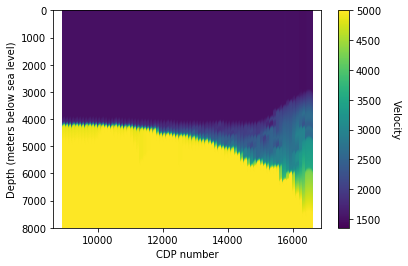

In [8]:
image = plt.scatter(df['CDP'],df['Depth'], c=df['Velocity'], vmin=1350, vmax=5000)
plt.ylim(0,8000)
plt.gca().invert_yaxis()
cbar = plt.colorbar(image, orientation = 'vertical')
cbar.set_label("Velocity", rotation=270, labelpad=20)
plt.xlabel('CDP number')
plt.ylabel('Depth (meters below sea level)')
plt.show()

Here's a structual seismic reflection image showing a little more detail on what's going on (although the area displayed is slightly shifted) (Olsen et al., in review, EPSL):

<img src="028.png" width="400"> 

<br />

We can also look at the stats to see the extent of the velocity. The way I made this file, the max velocity should be 6,000 m/s, and the min is defined based on water p-wave velocity. This also lets me know my depth is 10,000 m.

In [9]:
df.describe()

,Line,CDP,Depth,Velocity
count,152075.0,152075.000000,152075.000000,152075.000000
mean,28.0,12750.024659,5000.032879,3646.550847
std,0.0,2193.734446,2888.184893,1991.251158
min,28.0,9000.000000,0.000000,1489.000000
25%,28.0,10900.000000,2500.000000,1500.000000
50%,28.0,12800.000000,5000.000000,4442.000000
75%,28.0,14650.000000,7500.000000,5633.000000
max,28.0,16500.000000,10000.000000,6000.000000


The porosity vs depth data need to be extended, because they only go to 361 m. To train the data for the full velocity values I have, I need to extrapolate with a model based on the relationship:
φ(z)=φ1+(φ0−φ1)e$−kz$ 

φ(z) is the porosity at a certain depth, φ1 is minimu porosity, φ0 is initial porosity, and k is a factor dependent on rock type. I've adjusted these to best fit my data. (Athy, L. F., 1930. Density, porosity, and compaction of sedimentary rocks: American Association of Petroleum Geologists Bulletin, v. 14.)

I'm also going to add noise to both the depth and porosity values to make it more realistic and to match my actual porosity data.

In [10]:
z = np.linspace(365,5000.0,927)
phi0 =70
phi1 = .3
k = 0.0009

zz = z + np.random.normal(0,50,927)
phi_zz = (phi1 + (phi0 - phi1)*np.exp(-k*zz) + np.random.normal(0,4,927)).tolist()

I'm made the extended dataset, and I'm now going to plot it with the measured values.

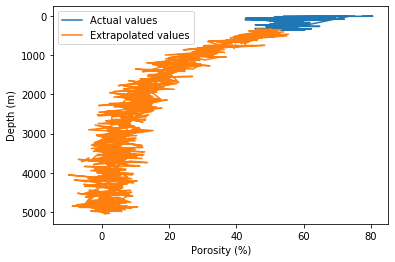

In [11]:
plt.xlabel('Porosity (%)')
plt.ylabel('Depth (m)')
plt.plot(working_data['PO (%)'],working_data['Depth (mbsf)'],label='Actual values')
plt.plot(phi_zz,zz,label='Extrapolated values')
plt.legend()
plt.gca().invert_yaxis()

It matches well! And the noise is similar to the actual data. I'm going to add these to a new pandas dataframe.

In [12]:
pors = working_data['PO (%)'].tolist()
pors = pors + phi_zz
depths = working_data['Depth (mbsf)'].tolist()
depths.extend(zz)
pordata = pd.DataFrame({'Depth (mbsf)': depths,'PO (%)': pors})

## Feature Manipulation/Data Prep
Here's where I catagorize the data as either water (velocity less than 1510 m/s), oceanic crust (velocity > 4700), and sediment. This will be used later, when sediment velocity is used to predict porosity

In [13]:
df['Material'] = np.where(df['Velocity'] < 1510, 'Water',
                           np.where(df['Velocity'] > 4700, 'Oceanic Crust', 'Sediment'))
df.head()

,Line,CDP,Depth,Velocity,Material
0,28,9000,5,1499,Water
1,28,9000,10,1499,Water
2,28,9000,15,1499,Water
3,28,9000,20,1499,Water
4,28,9000,25,1499,Water


I've added the material section, and now I'll checking to make sure I accurately catagorized the data (in a very translucent way, I'm sure there's a better way to do this). Green is crust, blue is ocean, and orange is the incoming sediment and subducting/accreting sediment. 

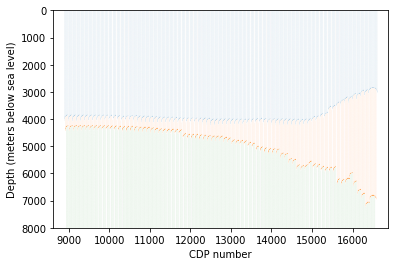

In [14]:
sns.scatterplot(df['CDP'],df['Depth'],hue=df['Material'], legend = False, size=df['Material'])
plt.ylim(0,8000)
plt.gca().invert_yaxis()
plt.xlabel('CDP number')
plt.ylabel('Depth (meters below sea level)')
plt.show()

I now need to match the depths of the porosity values to the velocity values. My velocity is sampled every 5 meters, so I'm going to round porosity to the nearest 5. I can't just match them directly because porosity data was more sparsely and randomly sampled. This means there might be depth values with multiple porosity values -- this will translate to the same velocity values mapping to certain porosities. This just adds noise to the data

In [15]:
import warnings 
warnings.filterwarnings('ignore')
pordata['Depth_r5'] = baseround(pordata['Depth (mbsf)'],base = 5)
pordata.head(8)

,Depth (mbsf),PO (%),Depth_r5
0,0.74,75.1,0.0
1,2.25,68.0,0.0
2,3.75,68.1,5.0
3,5.26,53.9,5.0
4,6.76,66.3,5.0
5,8.26,66.7,10.0
6,19.24,59.3,20.0
7,20.73,58.1,20.0


Adding the random variables also added some negative terms for porosity, which is not possible. I'm going to truncate values at 0.3% porosity.

In [16]:
pordata['PO (%)'] = np.where(pordata['PO (%)']>0.29, pordata['PO (%)'], 0.3) # conditional statement assign a new feature
pordata.head(1000)

,Depth (mbsf),PO (%),Depth_r5
0,0.740000,75.100000,0.0
1,2.250000,68.000000,0.0
2,3.750000,68.100000,5.0
3,5.260000,53.900000,5.0
4,6.760000,66.300000,5.0
...,...,...,...
995,4523.564238,4.896677,4525.0
996,4483.981762,1.326498,4485.0
997,4495.580479,0.300000,4495.0
998,4511.331171,0.300000,4510.0


I'll now visualize the porosity vs depth profile again to QC

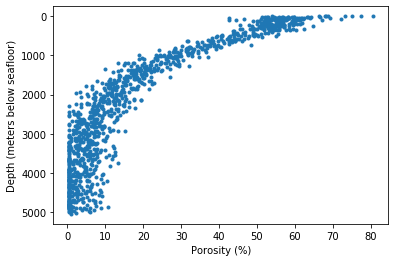

In [17]:
plt.scatter(pordata['PO (%)'], pordata['Depth_r5'],marker='.')
plt.gca().invert_yaxis()
plt.xlabel('Porosity (%)')
plt.ylabel('Depth (meters below seafloor)')
plt.show()

I'm using CDP 16500 to match my porosity and velocity data, this is the deepest sediment point I have. I will now need to assign a velocity value to every depth that has a porosity value. I do that in the code below. The porosity values are shifted to match seafloor depths at CDP 16500. I'm getting the seafloor depth at 16500 so I can add it to the porosity data depths to match the seismic

In [18]:
SF28 = SF[SF["CDP"] == 16500]
SF28

,Line,CDP,Depth
6756,28,16500.0,3105.68


I am also getting the row index at CDP 16500. This is so I can itialize the count in the loop below at this count to map through all depth values at CDP 16500.

In [19]:
df16500 = df[df["CDP"] == 16500]
df16500

,Line,CDP,Depth,Velocity,Material
150074,28,16500,0,1499,Water
150075,28,16500,5,1499,Water
150076,28,16500,10,1499,Water
150077,28,16500,15,1499,Water
150078,28,16500,20,1499,Water
...,...,...,...,...,...
152070,28,16500,9980,6000,Oceanic Crust
152071,28,16500,9985,6000,Oceanic Crust
152072,28,16500,9990,6000,Oceanic Crust
152073,28,16500,9995,6000,Oceanic Crust


Now I'm going to map velocity values (from location cdp = 16500) to each depth value in the porosity dataset. This is used so I can train the data at this location then apply it to the entire seismic velocity section.

To do this, I am looping through each depth value of the porosity data, and trying to match depth value of the velocity data to this. I take the velocity value at that depth and add it to a list so I can directly map porosity to velocity data. I have an error in place that will come up if I miss some points or somehow add additional points.

In [20]:
sf28 = SF28.at[6756,'Depth'] - 100    #the seafloor at the location of CDP 16500. After some QC'ing, it seems my pick
#is off by ~100 m, so I'm shifting it here
df16500_val = 150074


porvels = []
count = df16500_val;   #the first instance of CDP 16500
for d1 in pordata['Depth_r5']:
    dr = d1 + baseround(sf28,5)
    for d2 in df16500['Depth']:
        if dr == d2:
            vel = df16500.at[count,'Velocity']
            porvels.append(vel)
        count = count + 1
    count = df16500_val

#making sure my I mapped a velocity value to every depth with a porosity reading
if len(porvels) != len(pordata):
    print('points were dropped')


Now adding that velocity vector to the porosity dataframe so I can directly relate porosity to velocity

In [21]:
pordata['Velocity'] = porvels
pordata.head(15)

,Depth (mbsf),PO (%),Depth_r5,Velocity
0,0.74,75.1,0.0,1521
1,2.25,68.0,0.0,1521
2,3.75,68.1,5.0,1526
3,5.26,53.9,5.0,1526
4,6.76,66.3,5.0,1526
5,8.26,66.7,10.0,1532
6,19.24,59.3,20.0,1545
7,20.73,58.1,20.0,1545
8,22.24,53.0,20.0,1545
9,23.75,58.1,25.0,1552


These values make sense - high porosity sediment will have p-wave velocities dominated by water velocity, and will decrease as porosity increases.

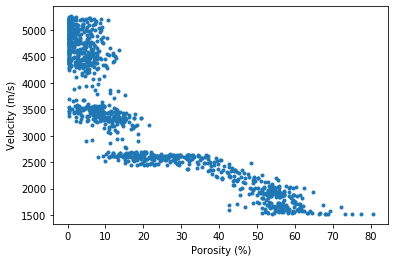

In [22]:
plt.scatter(pordata['PO (%)'],pordata['Velocity'], marker = '.')
#plt.gca().invert_yaxis()
plt.ylabel('Velocity (m/s)')
plt.xlabel('Porosity (%)')
plt.show()

Taking a look at it -- it doesn't look super smooth, but for the values I have, this is pretty expected. Here's an example where someone has looked at a velocity-porosity relationship for sediments in the Cascadia trench, and various porosity-velocity relationships, and it looks similar. The relationship is a bit messy, and there is not one velocity value for each porosity value, and vice versa. This is also observed in nature -- the velocity, porosity relationship has a general trend, but is overall quite complex, with variations due to lithology, pore structure, anisotropy, consolidation history, etc. For more information, see: Erickson, S. N., & Jarrard, R. D. (1998). Velocity‐porosity relationships for water‐saturated siliciclastic sediments. Journal of Geophysical Research: Solid Earth, 103(B12), 30385-30406.
<img src="vel_por_relat.png" width="400">
<center>Han et al., 2017</center>

This figure also shows us that while empirical relationships exist between porosity and velocity, there is not one, set relationship.


## Machine Learning
Now I'm going to make the prediction models. First I need to split the data to train/test, so I can evaluate how the model is performing.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(pordata['Velocity'], pordata['PO (%)'], test_size=0.20, random_state=594170)
y_train = pd.DataFrame({'Porosity':y_train.values})
y_test = pd.DataFrame({'Porosity':y_test.values})
X_train = pd.DataFrame({'Velocity':X_train.values})
X_test = pd.DataFrame({'Velocity':X_test.values})
X_train.head()

,Velocity
0,4573
1,2509
2,2648
3,3262
4,4746


Erickson and Jarrard (1998) come up with a velocity-porosity relationship empirically:
#### Vp = 3.0-4.21$\phi$	 + 3.07$\phi$$^2$		

So I could try to come up with a model that predicts in the form of:
#### $\phi$ = $-b \pm \sqrt{b^2 - 4acVp} \over 2a$

But I could also use Decision Tree methods -- these easily and quickly catagorize the data, which is nice because we have 120,000 velocity datapoints to map to porosity. See introduction for more information on decision trees.

For each case, I'm going to build the model with the training data, then apply it to the testing data, then add the predicted results to the actual testing values and evaluate the correlation.

In [24]:
dtree = DecisionTreeRegressor().fit(X_train,y_train)
preds = dtree.predict(X_test)
y_test['DTree'] = preds
y_test.corr() 

,Porosity,DTree
Porosity,1.000000,0.966716
DTree,0.966716,1.000000


This is already a very good correlation. We can visualize it as well.

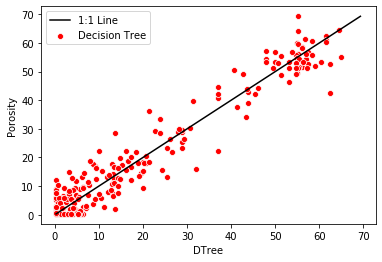

In [25]:
plt.subplot(111)
x = np.linspace(start = np.min(y_test['Porosity']),stop = np.max(y_test['Porosity']), num = 1000)
y = x
sns.scatterplot(y_test['DTree'],y_test['Porosity'], color = 'red',label='Decision Tree')
plt.plot(x,y,color='black', label = '1:1 Line')
plt.legend()
plt.show()

Looks good. We're now going to try random forest. Summarized from Wikipedia: "Random forests are an ensemble learning method for regression that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the mean prediction of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set."

I'm not going to prescribe any of the parameters at this point -- we'll do that at the next step.

In [26]:
import warnings 
warnings.filterwarnings('ignore')

forest = RandomForestRegressor()
forest.fit(X_train,y_train)
forest_preds = forest.predict(X_test)
y_test['Forest'] = forest_preds
y_test.corr()

,Porosity,DTree,Forest
Porosity,1.000000,0.966716,0.972600
DTree,0.966716,1.000000,0.995916
Forest,0.972600,0.995916,1.000000


Again, a very good correlation. Could it be improved though? I'm now going to use a grid search package to optimize the values for max depth and minimum samples to split and then will predict with this. In this way, I don't need to guess which parameter values will perform best. What this package does is makes a number of models with the prescribed hyperparameters, and evaluate what best reduces model variance and model bias. More information can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [27]:
import warnings 
warnings.filterwarnings('ignore')

parameters = {'max_depth':np.linspace(1,20,20),'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
clf = GridSearchCV(forest, parameters)
clf.fit(X_train,y_train)
#clf.cv_results_
clf_pred = clf.predict(X_test)
y_test['Tuned HP'] = clf_pred

This should now have optimized the max depth and min samples to split. We can compare this correlation to the other models.

In [28]:
y_test.corr()

,Porosity,DTree,Forest,Tuned HP
Porosity,1.000000,0.966716,0.972600,0.975612
DTree,0.966716,1.000000,0.995916,0.987792
Forest,0.972600,0.995916,1.000000,0.993570
Tuned HP,0.975612,0.987792,0.993570,1.000000


Looking at the correlation with the actual data, this has the best score. However, this model did take quite a bit longer to instantiate, and only performed marginally better. We can plot it to see how it compares with random forest.

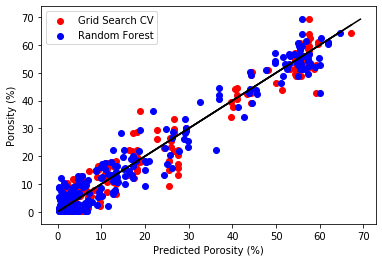

In [29]:
plt.subplot(111)
plt.scatter(clf_pred,y_test['Porosity'], color = 'red',label='Grid Search CV')
plt.scatter(y_test['Forest'],y_test['Porosity'], color = 'blue', label='Random Forest')
x = np.linspace(start = np.min(y_test),stop = np.max(y_test), num = 1000)
y = x
plt.xlabel('Predicted Porosity (%)')
plt.ylabel('Porosity (%)')
plt.legend()
plt.plot(x,y,color='black')
plt.show()

Overall, it seems to perform very similarly, both by the correlation coefficient and the quantitative visualization.

I'm going to apply each of these models to the full velocity dataset now. The code below now takes the full dataset, checks to see if the material is sediment, then predicts porosity with each prediction model. If the material is not sediment, I'm assigning a value of 0 porosity -- I'm only keeping these placeholders so I can visualize the porosity in a similar way that I did with the velocity data in the first figure.

In [30]:
#going through and assigning porosity values to the sediment (water and ocean crust are given values of 0)
portree = [];
porfor = [];
porclf = [];
for row in df.index:
    mat = df.at[row,'Material']
    if mat == 'Sediment':
        vel = df.at[row,'Velocity'].reshape(1, -1)
        por_tree = dtree.predict(vel)
        por_for = forest.predict(vel)
        por_clf = clf.predict(vel)
        portree.append(por_tree)
        porfor.append(por_for)
        porclf.append(por_clf)
    
    else:
        portree.append(0)
        porfor.append(0)
        porclf.append(0)


df['Por Tree'] = portree       
df['Por Forest'] = porfor
df['Por Gridded Search'] = porclf
df.head(860)

,Line,CDP,Depth,Velocity,Material,Por Tree,Por Forest,Por Gridded Search
0,28,9000,5,1499,Water,0,0,0
1,28,9000,10,1499,Water,0,0,0
2,28,9000,15,1499,Water,0,0,0
3,28,9000,20,1499,Water,0,0,0
4,28,9000,25,1499,Water,0,0,0
...,...,...,...,...,...,...,...,...
855,28,9000,4280,3201,Sediment,[9.057328090039508],[10.103340849891097],[11.826459342637607]
856,28,9000,4285,3348,Sediment,[9.830919581603187],[10.470623951180377],[11.290910409284626]
857,28,9000,4290,3495,Sediment,[3.9942568880078806],[4.692912375303551],[5.567189074846664]
858,28,9000,4295,3642,Sediment,[9.12029453265992],[7.916502033434389],[7.015924093577342]


## Summary of Results
The predictions were added successfully! I'm now going to visualize the porosity-velocity relationship to see how it looks.

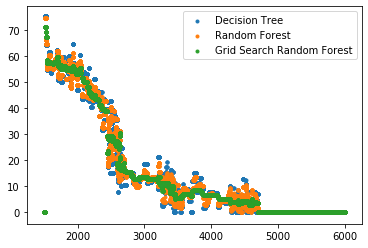

In [31]:
plt.scatter(df['Velocity'],df['Por Tree'],label='Decision Tree',marker = '.')
plt.scatter(df['Velocity'],df['Por Forest'],label='Random Forest',marker = '.')
plt.scatter(df['Velocity'],df['Por Gridded Search'],label='Grid Search Random Forest',marker = '.')
plt.legend()
plt.show()

Overall, they each capture the trend very similarly. The main differences are in the variance - decision tree and random forest seem to have similar variance, while the grid search random forest has much less. The zero values are from the areas that are not sediments -- water and crust. Lets see how this looks as a cross section in 2D space:

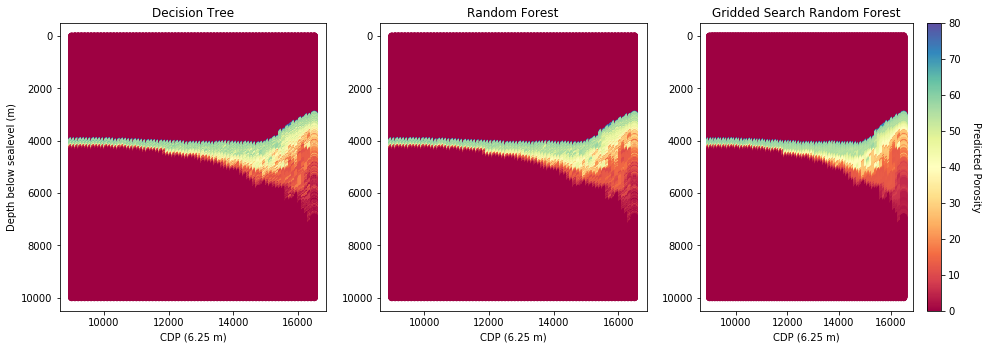

In [32]:
plt.subplot(131)
image = plt.scatter(df['CDP'],df['Depth'], c=df['Por Tree'], vmin=0, vmax=80,cmap='Spectral')
plt.gca().invert_yaxis()
plt.ylabel('Depth below sealevel (m)')
plt.xlabel('CDP (6.25 m)')
plt.title('Decision Tree')

plt.subplot(132)
image2 = plt.scatter(df['CDP'],df['Depth'], c=df['Por Forest'], vmin=0, vmax=80,cmap='Spectral')
plt.gca().invert_yaxis() 
plt.xlabel('CDP (6.25 m)')
plt.title('Random Forest')

plt.subplot(133)
image3 = plt.scatter(df['CDP'],df['Depth'], c=df['Por Gridded Search'], vmin=0, vmax=80,cmap='Spectral')
plt.xlabel('CDP (6.25 m)')
plt.gca().invert_yaxis()
plt.title('Gridded Search Random Forest')

cbar = plt.colorbar(image, orientation = 'vertical')
cbar.set_label("Predicted Porosity", rotation=270, labelpad=20)
plt.xlabel('CDP (6.25 m)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.1, top=1.0, wspace=0.2, hspace=0.2)

Again, overall, the models performed very similarly. Random forest appears smoother than just one decision tree. Gridded search random forest clearly has less regions to catagorize -- based on this, it may be that the other two models are actually overfit. It might be best to stop with a more pruned tree to more accurately predict porosity. However, we know from coring everywhere that the porosity values are likely not that discrete -- this leads me to be more inclined to use the random forest model.